<a href="https://colab.research.google.com/github/addalasaikishore/info5731_spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

# **Downloading and Installing required modules**

**Installing nltk and stopwords**

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Installing java**

In [2]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


**Upgrading Gensim**

In [5]:
!pip install --upgrade gensim
!pip install pyLDAvis

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)
     |████████████████████████████████| 1.7MB 7.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=8ee3ae3538b992eee3635fa5036167d14105f4229fda9bce704028e6d47ac26f
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


**Downloading en module in spicy**

In [6]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


##Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

**Importing Required Modules**

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


**Importing Stopwords module from nltk**

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

**Reading Google Articles from csv to df**

In [11]:
google_articles_titles = pd.read_csv('data.csv', encoding = "ISO-8859-1")
google_articles_titles.head(10)

,Review Title
0,Machine learning comparison between WorldView-...
1,Unintended consequences of machine learning in...
2,Trend analysis in machine learning research us...
3,Machine learning applications in cancer progno...
4,Nanomaterial synthesis insights from machine l...
5,Implementation of machine-learning classificat...
6,A review of using machine learning approaches ...
7,Exploring characteristics of online news comme...
8,A review of research on machine learning in ed...
9,Literature review: Machine learning techniques...


**Dataframe to list**

In [12]:
data = google_articles_titles['Review Title'].tolist()

**Tokenization and punctuation**

In [13]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

**Building Bigrams and Trigrams models**

In [14]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

**Removing Stopwords and getting Bigrams**

In [15]:
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

**Lemmatization**

In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

**Building Dictionary, Corpus and Term Document Frequency**

In [17]:
id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('language', 1), ('natural', 1), ('processing', 1)]]

**Building LDA Model with 20 topics**

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Compute Model Perplexity and Coherence Score**

In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.142866884242921

Coherence Score:  0.425556298428403


**Setting environment Path and giving Mallet Path**

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

**Building LDA Mallet Model**

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Compute Coherence Value for LDA**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


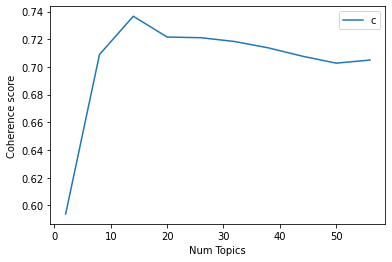

In [ ]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.5938
Num Topics: 8  - Coherence Value: 0.709
Num Topics: 14  - Coherence Value: 0.7367
Num Topics: 20  - Coherence Value: 0.7216
Num Topics: 26  - Coherence Value: 0.7211
Num Topics: 32  - Coherence Value: 0.7184
Num Topics: 38  - Coherence Value: 0.7138
Num Topics: 44  - Coherence Value: 0.7078
Num Topics: 50  - Coherence Value: 0.7028
Num Topics: 56  - Coherence Value: 0.705


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Printing Topics**

In [20]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.190*"machine" + 0.190*"learning" + 0.190*"consequence" + 0.190*"medicine" '
  '+ 0.190*"unintended" + 0.001*"comment" + 0.001*"explore" + 0.001*"approach" '
  '+ 0.001*"commenter" + 0.001*"news"'),
 (1,
  '0.020*"implementation" + 0.020*"visualize" + 0.020*"sense" + 0.020*"review" '
  '+ 0.020*"remote" + 0.020*"education" + 0.020*"applied" + 0.020*"scientific" '
  '+ 0.020*"structure" + 0.020*"precision"'),
 (2,
  '0.033*"machine" + 0.030*"learning" + 0.027*"approach" + 0.024*"explore" + '
  '0.024*"comment" + 0.024*"commenter" + 0.024*"news" + 0.021*"education" + '
  '0.021*"consequence" + 0.021*"medicine"'),
 (3,
  '0.046*"use" + 0.031*"text" + 0.031*"research" + 0.031*"machine" + '
  '0.031*"mining" + 0.029*"review" + 0.029*"education" + 0.029*"approach" + '
  '0.029*"precision" + 0.029*"learning"'),
 (4,
  '0.022*"nanomaterial" + 0.022*"insight" + 0.022*"article" + 0.022*"machine" '
  '+ 0.022*"structure" + 0.022*"synthesis" + 0.022*"extract" + '
  '0.022*"visualize" + 0.

**Topic Visualization**

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.079359 -0.094244       1        1  19.763981
7     -0.139875  0.014646       2        1  19.030780
2     -0.072799 -0.017332       3        1  11.146665
6     -0.083941 -0.031549       4        1  11.072735
1     -0.077492  0.017788       5        1   9.613659
5     -0.041845  0.124536       6        1   7.495433
3     -0.068610  0.000320       7        1   5.395464
11    -0.016923  0.065027       8        1   5.290640
0      0.016258 -0.062803       9        1   4.193556
8      0.006909  0.001350      10        1   2.587881
4      0.057663 -0.020597      11        1   2.361545
10     0.181853  0.005126      12        1   1.137734
9      0.158983 -0.001091      13        1   0.456555
13     0.159177 -0.001178      14        1   0.453372, topic_info=           Term       Freq      Total Category  logprob  loglift
1       natural  78.000000  78.000000  Default  30.0000  30.0000
0      language  81.000000  81.000000  Default  29.0000  29.0000
61  information   5.000000   5.000000  Default  28.0000  28.0000
2    processing  76.000000  76.000000  Default  27.0000  27.0000
62    retrieval   3.000000   3.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
64      cluster   0.013425   1.408820  Topic14  -5.4424   0.7428
63      chinese   0.013425   1.408845  Topic14  -5.4424   0.7428
62    retrieval   0.013425   3.391742  Topic14  -5.4424  -0.1358
61  information   0.013425   5.493238  Topic14  -5.4424  -0.6180
60        topic   0.013425   1.408473  Topic14  -5.4424   0.7430

[684 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
211       3  0.699025  abstract
16        4  0.700392   acquire
186       3  0.468755    active
186       8  0.468755    active
190       3  0.699025   advance
...     ...       ...       ...
161       2  0.317912       web
161       4  0.317912       web
68        5  0.709800   whisper
168       4  0.700392      word
176       3  0.699025      year

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 8, 3, 7, 2, 6, 4, 12, 1, 9, 5, 11, 10, 14])